# Deterministic Modelling for LacY and T7

In [27]:
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline
from scipy.integrate import odeint
from scipy.integrate import ode

In [28]:
#to have [R2]T reach 2000 instead of 20
k_smr = 24.67
#k_smr = 0

k_sr = 15
k_2r = 50
k_Neg_2r = 1e-3
k_ry = 960
k_Neg_ry = 2.4
k_dr1 = 3e-7
k_Neg_dr1 = 12
k_dr4 = 3e-7
k_Neg_dr4 = 4.8e3
k_s0my = 0.01
k_s1my = 0.5
k_sy = 30
k_p = 0.12
k_Neg_p = 0.1
k_ft = 6e4
k_t = 0.92

lambda_mr = 0.462
lambda_r = 0.2
lambda_i2r2 = 0.2
lambda_r2 = 0.2
lambda_my = 0.462
lambda_y = 0.2
lambda_yiex = 0.2


#rates for t7
k_s0mt7 = 0.01
k_rt7 = 960
k_Neg_rt7 = 2.4
k_dr2 = 3e-7
k_Neg_dr2 = 4.8e3

#rates to be modified；at R = 0, T7_mRNA = 667, T7 = 14673
k_s1mt7 = 148.15
lambda_mt7 = 0.462
k_st7 = 4.4
lambda_t7 = 0.2


#rates for cre
k_s0mcre = 0.01
k_rcre = 960
k_Neg_rcre = 2.4
k_dr3 = 3e-7
k_Neg_dr3 = 4.8e3

k_s1mcre = 28.3
lambda_mcre = 0.462
k_scre = 4.4
lambda_cre = 0.2

In [29]:
def f(y, t):
     mr = y[0]
     r = y[1]
     r2 = y[2]
     oy = y[3]
     ot7 = y[4]
     ocre = y[5]
     i = y[6]   
     i2r2 = y[7]
     my = y[8]
     lac_Y = y[9]
     mt7 = y[10]
     t7 = y[11]
     mcre = y[12]
     cre = y[13]   
     yiex = y[14]
     #iex = y[13]

     f0 = k_smr - lambda_mr*mr
     f1 = k_sr*mr - 2*k_2r*r*r + 2*k_Neg_2r*r2 - lambda_r*r
     f2 = k_2r*r*r - k_Neg_2r*r2 - k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) - k_ry*r2*oy + k_Neg_ry*(2.08-oy) - k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) - k_dr1*i*i*r2 + k_Neg_dr1*i2r2 - lambda_r2*r2
     f3 = -k_ry*r2*oy + k_Neg_ry*(2.08-oy) + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy
     f4 = -k_rt7*r2*ot7 + k_Neg_rt7*(2.08-ot7) + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7
     f5 = -k_rcre*r2*ocre + k_Neg_rcre*(60-ocre) + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre      
     f6 = -2*k_dr1*r2*i*i + 2*k_Neg_dr1*i2r2 - 2*k_dr2*(2.08-ot7)*i*i + 2*k_Neg_dr2*ot7*i2r2 - 2*k_dr3*(60-ocre)*i*i + 2*k_Neg_dr3*ocre*i2r2 - 2*k_dr4*(2.08-oy)*i*i + 2*k_Neg_dr4*oy*i2r2 + k_ft*yiex + k_t*(iex-i) + 2*lambda_i2r2*i2r2 + lambda_yiex*yiex
     f7 = k_dr1*i*i*r2 - k_Neg_dr1*i2r2 + k_dr2*i*i*(2.08-ot7) - k_Neg_dr2*i2r2*ot7 + k_dr3*i*i*(60-ocre) - k_Neg_dr3*i2r2*ocre + k_dr4*i*i*(2.08-oy) - k_Neg_dr4*i2r2*oy - lambda_i2r2*i2r2
     f8 = k_s0my*(2.08-oy) + k_s1my*oy - lambda_my*my
     f9 = k_sy*my + (k_ft + k_Neg_p)*yiex - k_p*lac_Y*iex - lambda_y*lac_Y
     f10 = k_s0mt7*(2.08-ot7) + k_s1mt7*ot7 - lambda_mt7*mt7    
     f11 = k_st7*mt7 - lambda_t7*t7
     f12 = k_s0mcre*(60-ocre)*t7 + k_s1mcre*ocre*t7 - lambda_mcre*mcre   
     f13 = k_scre*mcre - lambda_cre*cre
     f14 = -(k_ft + k_Neg_p)*yiex + k_p*lac_Y*iex - lambda_yiex*yiex  
     #f13 = k_t*(i-iex) - k_p*lac_Y*iex + k_Neg_p*yiex 
     return [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14]


In [30]:
mr_0 = 0
r_0 = 0
r2_0 = 0
oy_0 = 2.08
ot7_0 = 2.08
ocre_0 = 60
i_0 = 0
i2r2_0 = 0
my_0 = 0
lac_Y_0 = 0
mt7_0 = 0
t7_0 = 0
mcre_0 = 0
cre_0 = 0
yiex_0 = 0
#iex_0 = 100000
 
y0 = [mr_0, r_0, r2_0, oy_0, ot7_0, ocre_0, i_0, i2r2_0, my_0, lac_Y_0, mt7_0, t7_0, mcre_0, cre_0, yiex_0]     

In [31]:
plt.ion()
plt.rcParams['figure.figsize'] = 10, 8

0 IPTG, MT7:  0.0458549085941
0 IPTG, T7:  1.008808113
400,000 IPTG, MT7:  12.1950236449
400,000 IPTG, T7:  268.505867011
500,000 IPTG, MT7:  161.494009961
500,000 IPTG, T7:  3439.44723332


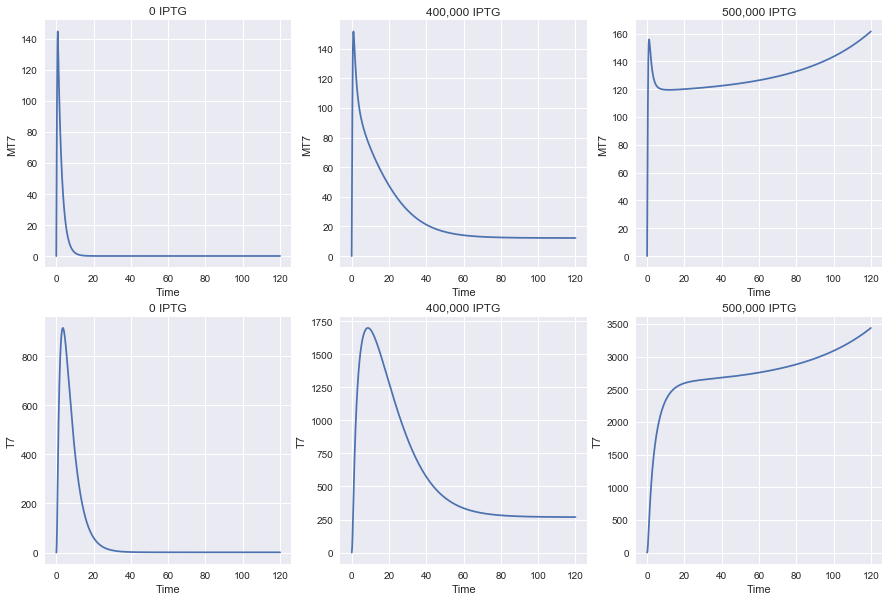

In [32]:
t  = np.linspace(0, 120, 10000) 
iex = 0

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]
    
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.plot(t, mt7_s)
plt.title('0 IPTG')
plt.ylabel('MT7')
plt.xlabel('Time')

plt.subplot(2, 3, 4)
plt.plot(t, t7_s)
plt.title('0 IPTG')
plt.ylabel('T7')
plt.xlabel('Time')

print("0 IPTG, MT7: ", mt7_s[9999])
print("0 IPTG, T7: ", t7_s[9999])

iex = 400000

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]

plt.subplot(2, 3, 2)
plt.plot(t, mt7_s)
plt.title('400,000 IPTG')
plt.ylabel('MT7')
plt.xlabel('Time')

plt.subplot(2, 3, 5)
plt.plot(t, t7_s)
plt.title('400,000 IPTG')
plt.ylabel('T7')
plt.xlabel('Time')

print("400,000 IPTG, MT7: ", mt7_s[9999])
print("400,000 IPTG, T7: ", t7_s[9999])

iex = 500000

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]

plt.subplot(2, 3, 3)
plt.plot(t, mt7_s)
plt.title('500,000 IPTG')
plt.ylabel('MT7')
plt.xlabel('Time')

plt.subplot(2, 3, 6)
plt.plot(t, t7_s)
plt.title('500,000 IPTG')
plt.ylabel('T7')
plt.xlabel('Time')

print("500,000 IPTG, MT7: ", mt7_s[9999])
print("500,000 IPTG, T7: ", t7_s[9999])

0 IPTG, MCre:  1.31477115344
0 IPTG, Cre:  28.9251622375
400,000 IPTG, MCre:  75.0424353252
400,000 IPTG, Cre:  1650.93550548
500,000 IPTG, MCre:  23050252.6173
500,000 IPTG, Cre:  507105534.969


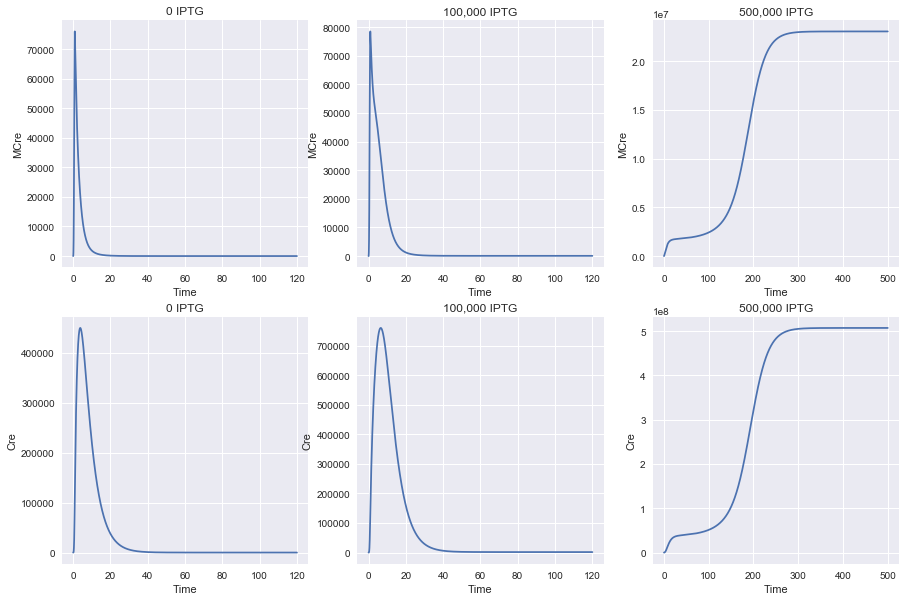

In [37]:
t  = np.linspace(0, 120, 10000) 
iex = 0

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]
    
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.plot(t, mcre_s)
plt.title('0 IPTG')
plt.ylabel('MCre')
plt.xlabel('Time')

plt.subplot(2, 3, 4)
plt.plot(t, cre_s)
plt.title('0 IPTG')
plt.ylabel('Cre')
plt.xlabel('Time')

print("0 IPTG, MCre: ", mcre_s[9999])
print("0 IPTG, Cre: ", cre_s[9999])

iex = 100000

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]

plt.subplot(2, 3, 2)
plt.plot(t, mcre_s)
plt.title('100,000 IPTG')
plt.ylabel('MCre')
plt.xlabel('Time')

plt.subplot(2, 3, 5)
plt.plot(t, cre_s)
plt.title('100,000 IPTG')
plt.ylabel('Cre')
plt.xlabel('Time')

print("400,000 IPTG, MCre: ", mcre_s[9999])
print("400,000 IPTG, Cre: ", cre_s[9999])

iex = 500000
t  = np.linspace(0, 500, 10000) 

soln = odeint(f, y0, t)

mr_s = soln[:, 0]
r_s = soln[:, 1]
r2_s = soln[:, 2]
oy_s = soln[:, 3]
ot7_s = soln[:, 4]
ocre_s = soln[:, 5]
i_s = soln[:, 6]
i2r2_s = soln[:, 7]
my_s = soln[:, 8]
lac_Y_s = soln[:, 9]
mt7_s = soln[:, 10]
t7_s = soln[:, 11]
mcre_s = soln[:, 12]
cre_s = soln[:, 13]
yiex_s = soln[:, 14]

plt.subplot(2, 3, 3)
plt.plot(t, mcre_s)
plt.title('500,000 IPTG')
plt.ylabel('MCre')
plt.xlabel('Time')

plt.subplot(2, 3, 6)
plt.plot(t, cre_s)
plt.title('500,000 IPTG')
plt.ylabel('Cre')
plt.xlabel('Time')

print("500,000 IPTG, MCre: ", mcre_s[9999])
print("500,000 IPTG, Cre: ", cre_s[9999])